It favors a low-density separation between classes, a commonly assumed prior for semi-supervised learning (Chapelle et al., 2005).

In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import numpy as np
import os
import time
import pandas as pd

if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')
%matplotlib inline
import os, sys
sys.path.append(os.getcwd())

import time

import numpy as np


import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch import nn
from torch import autograd
from torch import optim
import argparse
import csv


from torch.utils.data import TensorDataset, DataLoader, SequentialSampler, Dataset
from torch.utils.data.sampler import RandomSampler, SubsetRandomSampler
from torch.optim import AdamW, Adam

from torch.autograd import Variable

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# get_linear_schedule_with_warmup
import time
import os
import re

In [14]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [4]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [5]:
class MNIST_Dataset(Dataset):
    
    def __init__(self, dataset, *args, **kwargs):
        
        super(MNIST_Dataset, self, *args, **kwargs).__init__()
        self.dataset=dataset
        self.use_label_mask=np.zeros(len(dataset), dtype=bool)
    
    def __getitem__(self, idx):
        tmp=self.dataset[idx]
        return [*tmp, self.use_label_mask[idx],idx]
    
    def __len__(self):
        return len(self.dataset)

In [6]:
def choose_label_rand(dataset, nb_label, nb_class, train_indices):
    
    idx_label=[]
    nb_label_each_class=nb_label//nb_class
    
    early_stop=False
    
    if nb_label_each_class==0:
        print("The number of classes superior the number of desired labeled data.")
        print("This mean that some class(es) would not have example !")
        nb_label_each_class=1
        early_stop=True
    
    for i in range(nb_class):
        print(f"Choosing Random index for the class {i}")
        tmp=iter(dataset)
        idx_class=[datapoint[3] for datapoint in tmp if datapoint[1]==i and datapoint[3] in train_indices]
        idx_label.extend(np.random.choice(idx_class, nb_label_each_class, replace=False))
        if early_stop and i+1 == nb_label:
            break
    
    return idx_label

In [7]:
def evaluate(target, predicted):
    true_label_mask = [1 if (np.argmax(x)-target[i]) ==
                       0 else 0 for i, x in enumerate(predicted)]
    nb_prediction = len(true_label_mask)
    true_prediction = sum(true_label_mask)
    false_prediction = nb_prediction-true_prediction
    accuracy = true_prediction/nb_prediction
    return{
        "accuracy": accuracy,
        "nb exemple": len(target),
        "true_prediction": true_prediction,
        "false_prediction": false_prediction,
    }

In [8]:
# Discriminator Loss = (λ*supervised_Loss) + unsupervised_Loss - generator_loss

# Supervised Loss
# we use labeled data to calculate the Cross Entropy
def supervised_Loss_fun(logits, y_targets):
#         pdist = logits.gather(1, y_targets.view(-1, 1)).squeeze(1)
#         labeled = torch.logsumexp(logits, dim=1)
#         loss = -torch.mean(pdist) + torch.mean(labeled)
#         return loss
    loss=nn.CrossEntropyLoss()
    return loss(logits, y_targets)
    

# Unsupervised Loss
def unsupervised_Loss_fun(y_pred_unlabeled):
        unlabeled = torch.logsumexp(y_pred_unlabeled, dim=1)
        loss = -torch.mean(unlabeled) + torch.mean(F.softplus(unlabeled))
        return loss

# log( exp( log( sum( exp(x) ) ) ) +1) == log(  sum( exp(x) )  +1)



# Generator Loss = features_matching_loss + generator_loss

def generator_loss_fun(y_pred_fake):
    fake = torch.logsumexp(y_pred_fake, dim=1)
    return -torch.mean(F.softplus(fake))


# Semisupervised Loss
# we use the labeled and the non labeled data to do features matching with the data from the generator
def features_matching_loss_fun(discriminator_features, generator_features):
    loss = nn.MSELoss()
    return loss(discriminator_features, generator_features)



In [9]:
def train_loop_fun1(data_loader, discriminator, generator, optimizer_G, optimizer_D, latent_size, batch_size, device, λ=1, idx_label=None):
    discriminator.train()
    generator.train()
    t0 = time.time()
    
    losses_G = []
    losses_D = []
    
    unsupervised_losses=[]
    unsupervised_Losses=[]
    supervised_Losses=[]
    generator_losses=[]
    features_matching_losses=[]

    
    for batch_idx, (data, targets, use_label, data_idx) in enumerate(data_loader):
        
        
        #         batch_idx_label=[i for i, datapoint_idx in enumerate(data_idx) if datapoint_idx in idx_label]
        #         data=torch.flatten(data, start_dim=1)
        
        

#         * Updating the Discriminator *


        # freeze the generator and update the Discriminator
        for p in discriminator.parameters():  
            p.requires_grad = True  
        for p in generator.parameters(): 
            p.requires_grad = False  

        discriminator.zero_grad()

        
#         train with real data

        y_real, features_real = discriminator(data)
        
        # unsupervised
        unsupervised_Loss=unsupervised_Loss_fun(y_real)

        # supervised
        supervised_Loss=torch.tensor(0)
        idx_label=torch.where(use_label)[0]
        if len(idx_label)>0:
            # we the Cross Entropy for the supervised loss
            supervised_Loss = supervised_Loss_fun(y_real, targets)

#             train with fake data

        #uniform distribution sampling
        z = torch.randn(batch_size,latent_size, 1, 1).to(device=device)
        fake_images = generator(z)
        y_fake, features_fake = discriminator(fake_images)

        generator_loss = generator_loss_fun(y_fake)

        unsupervised_loss = unsupervised_Loss - generator_loss
        loss_D = unsupervised_loss + (λ*supervised_Loss)
        
        loss_D.backward(retain_graph=True)
        optimizer_D.step()
        

        
#         * Updating the Generator *


        # freeze the generator and update the Discriminator
        for p in discriminator.parameters():
            p.requires_grad = False  
        for p in generator.parameters():
            p.requires_grad = True  
        generator.zero_grad()

        #features matching
        features_matching_loss=features_matching_loss_fun(features_real, features_fake)

        loss_G = features_matching_loss + generator_loss

        loss_G.backward(retain_graph=True)
        optimizer_G.step()
        
        losses_G.append(loss_G.item())
        losses_D.append(loss_D.item())
        
        unsupervised_losses.append(unsupervised_loss.item())
        unsupervised_Losses.append(unsupervised_Loss.item())
        supervised_Losses.append(supervised_Loss.item())
        generator_losses.append(generator_loss.item())
        features_matching_losses.append(features_matching_loss.item())
        
        retrieve_every=150
        if batch_idx % retrieve_every == 0:
            print(
                f"___ batch index = {batch_idx} / {len(data_loader)} ({100*batch_idx / len(data_loader):.2f}%), time = {time.time()-t0:.2f} secondes ___")
            print(
                f"\tDiscriminator loss = {np.mean(losses_D[-retrieve_every:]):.2f}, Unsupervised loss = {np.mean(unsupervised_losses[-retrieve_every:]):.2f}, Supervised loss = {np.mean(supervised_Losses[-retrieve_every:]):.2f}")
            print(
                f"\tGenerator loss (global) = {np.mean(losses_G[-retrieve_every:]):.2f}, Feature Matching loss = {np.mean(features_matching_losses[-retrieve_every:]):.2f}, Generator loss = {np.mean(generator_losses[-retrieve_every:]):.2f}")
            t0 = time.time()
    return losses_G, losses_D, unsupervised_Losses, supervised_Losses, generator_losses, features_matching_losses, unsupervised_losses

In [10]:
def eval_loop_fun1(data_loader, discriminator, generator, latent_size, batch_size, device, λ=1, idx_label=None):
    discriminator.eval()
    generator.eval()
    fin_targets = []
    fin_outputs = []
    
    losses_D = []
    losses_G = []
    
    unsupervised_losses=[]
    unsupervised_Losses=[]
    supervised_Losses=[]
    generator_losses=[]
    features_matching_losses=[]
    
    for batch_idx, (data, targets, use_label, data_idx) in enumerate(data_loader):

        
        with torch.no_grad():
                        
#             * loss of the Discriminator *
            
            y_real, features_real = discriminator(data)
            
            # unsupervised
            unsupervised_Loss=unsupervised_Loss_fun(y_real)

            # supervised
            supervised_Loss=torch.tensor(0)
            idx_label=torch.where(use_label)[0]
            if len(idx_label)>0:
                # we the Cross Entropy for the supervised loss
                supervised_Loss = supervised_Loss_fun(y_real, targets)

#             train with fake data

            #uniform distribution sampling
            z = torch.randn(batch_size,latent_size, 1, 1).to(device=device)
            fake_images = generator(z)
            y_fake, features_fake = discriminator(fake_images)

            generator_loss = generator_loss_fun(y_fake)
            
            unsupervised_loss = unsupervised_Loss - generator_loss
            loss_D = unsupervised_loss  + (λ*supervised_Loss)
            


#             * loss of the Generator *
            
            #features matching
            features_matching_loss=features_matching_loss_fun(features_real, features_fake)

            loss_G = features_matching_loss + generator_loss

        losses_G.append(loss_G.item())
        losses_D.append(loss_D.item())

        unsupervised_losses.append(unsupervised_loss.item())
        unsupervised_Losses.append(unsupervised_Loss.item())
        supervised_Losses.append(supervised_Loss.item())
        generator_losses.append(generator_loss.item())
        features_matching_losses.append(features_matching_loss.item())
        
        fin_targets.append(targets.cpu().detach().numpy())
        fin_outputs.append(y_real.cpu().detach().numpy())
    return np.concatenate(fin_outputs), np.concatenate(fin_targets), losses_D, losses_G, unsupervised_Losses, supervised_Losses, generator_losses, features_matching_losses, unsupervised_losses
#     return np.vstack(fin_outputs), np.vstack(fin_targets), losses

In [11]:
class Discriminator(nn.Module):
    def __init__(self, ndf=64, alpha=0.2, nc=1, drop_rate=0.2, num_classes=10):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Dropout2d(drop_rate/2.5),
            
            # input is (number_channels) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 3, bias=False),#1
            nn.LeakyReLU(alpha),
            nn.Dropout2d(drop_rate),
            # (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(alpha),
            # (ndf) x 8 x 8
            nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(alpha),
            nn.Dropout2d(drop_rate),
            # (ndf) x 4 x 4
            nn.Conv2d(ndf, ndf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(alpha),
            # (ndf * 2) x 4 x 4
            nn.Conv2d(ndf * 2, ndf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(alpha),
            # (ndf * 2) x 4 x 4
            nn.Conv2d(ndf * 2, ndf * 2, 3, 1, 0, bias=False),
            nn.LeakyReLU(alpha),
            # (ndf * 2) x 2 x 2
        )
        
        self.features = nn.AvgPool2d(kernel_size=2)

        self.class_logits = nn.Linear(
            in_features=(ndf * 2) * 1 * 1,
            out_features=num_classes + 1)
        

    def forward(self, inputs):
        out = self.main(inputs)

        features = self.features(out)
        features = features.squeeze()

        class_logits = self.class_logits(features)
        
        class_logits_upd = class_logits-class_logits[:,-1][:,None]
        
        return class_logits_upd, features


In [12]:
class Generator(nn.Module):
    def __init__(self, latent_size=10, ngf=64, alpha=0.2, nc=1):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            # noise is going into a convolution
            nn.ConvTranspose2d(latent_size, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(alpha),
            # (ngf * 4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(alpha),
            # (ngf * 2) x 8 x 8
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(alpha),
            # (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf, nc, 4, 2, 3, bias=False),#1->3
            nn.Tanh()
            # (nc) x 32 x 32
        )

    def forward(self, inputs):
        return self.main(inputs)

In [359]:
TRAIN_BATCH_SIZE=100
EPOCH=20
validation_split = .2
shuffle_dataset = True
random_seed= 42
device="cpu"
lr=3e-5#1e-3
nb_training_label=100
nb_class=10
latent_size=nb_class
λ=3
layer_dim=[784,1000,500,250,250,250,10]
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

print('Loading MNIST Dataset...')

dataset = MNIST('./data', transform=img_transform,train=True)# download=True)
mnist_dataset=MNIST_Dataset(dataset)

#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

idx_label=choose_label_rand(mnist_dataset, nb_training_label, nb_class, train_indices)
mnist_dataset.use_label_mask[idx_label]=True

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler)

valid_data_loader=DataLoader(
    mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler)


num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

discriminator=Discriminator(num_classes=nb_class)
generator=Generator(latent_size=nb_class)
optimizer_G=AdamW(generator.parameters(), lr=lr)
optimizer_D=AdamW(discriminator.parameters(), lr=lr)
# optimizer=Adam(model.parameters(), lr=lr, weight_decay=1e-5)
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                         num_warmup_steps = 0,
#                                         num_training_steps = num_training_steps)

val_losses_G=[]
val_losses_D=[]
batches_losses_D=[]
batches_losses_G=[]
val_acc=[]

unsupervised_Losses=[]
supervised_Losses=[]
generator_losses=[]
features_matching_losses=[]
unsupervised_losses=[]

val_unsupervised_Losses=[]
val_supervised_Losses=[]
val_generator_losses=[]
val_features_matching_losses=[]
val_unsupervised_losses=[]


for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp_G, batches_losses_tmp_D, unsupervised_Losses_tmp, supervised_Losses_tmp, generator_losses_tmp, features_matching_losses_tmp, unsupervised_losses_tmp=train_loop_fun1(train_data_loader, discriminator, generator, optimizer_G, optimizer_D, latent_size, TRAIN_BATCH_SIZE, device, λ)
    epoch_loss_D=np.mean(batches_losses_tmp_D)
    epoch_loss_G=np.mean(batches_losses_tmp_G)
    print(f"\n*** avg_Generator_loss : {epoch_loss_G:.2f}, avg_Discriminator_loss : {epoch_loss_D:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp_D, val_losses_tmp_G, val_unsupervised_Losses_tmp, val_supervised_Losses_tmp, val_generator_losses_tmp, val_features_matching_losses_tmp, val_unsupervised_losses_tmp=eval_loop_fun1(valid_data_loader, discriminator, generator, latent_size, TRAIN_BATCH_SIZE, device, λ)
    print(f"==> evaluation : avg_Generator_loss = {np.mean(val_losses_tmp_G):.2f}, avg_Discriminator_loss = {np.mean(val_losses_tmp_D):.2f}, time : {time.time()-t1:.2f} sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses_D.append(val_losses_tmp_D)
    val_losses_G.append(val_losses_tmp_G)
    batches_losses_D.append(batches_losses_tmp_D)
    batches_losses_G.append(batches_losses_tmp_G)
    
    unsupervised_Losses.append(unsupervised_Losses_tmp)
    supervised_Losses.append(supervised_Losses_tmp)
    generator_losses.append(generator_losses_tmp)
    features_matching_losses.append(features_matching_losses_tmp)
    unsupervised_losses.append(unsupervised_losses_tmp)
    
    val_unsupervised_Losses.append(val_unsupervised_Losses_tmp)
    val_supervised_Losses.append(val_supervised_Losses_tmp)
    val_generator_losses.append(val_generator_losses_tmp)
    val_features_matching_losses.append(val_features_matching_losses_tmp)
    val_unsupervised_losses.append(val_unsupervised_losses_tmp)
    
    print(f"\t§§ CatGAN model has been saved §§")
    torch.save(discriminator, f"mnist/SemiSupervisedGAN/discriminator/SemiSupervisedGAN_discriminator_model_epoch{epoch+1}.pt")
    torch.save(generator, f"mnist/SemiSupervisedGAN/generator/SemiSupervisedGAN_generator_model_epoch{epoch+1}.pt")    

Loading MNIST Dataset...
Choosing Random index for the class 0
Choosing Random index for the class 1
Choosing Random index for the class 2
Choosing Random index for the class 3
Choosing Random index for the class 4
Choosing Random index for the class 5
Choosing Random index for the class 6
Choosing Random index for the class 7
Choosing Random index for the class 8
Choosing Random index for the class 9

=============== EPOCH 1 / 20 ===============

___ batch index = 0 / 480 (0.00%), time = 0.36 secondes ___
	Discriminator loss = 2.80, Unsupervised loss = 2.80, Supervised loss = 0.00
	Generator loss (global) = -2.69, Feature Matching loss = 0.04, Generator loss = -2.73
___ batch index = 150 / 480 (31.25%), time = 58.98 secondes ___
	Discriminator loss = 2.43, Unsupervised loss = 1.28, Supervised loss = 0.38
	Generator loss (global) = -0.75, Feature Matching loss = 0.40, Generator loss = -1.15
___ batch index = 300 / 480 (62.50%), time = 62.11 secondes ___
	Discriminator loss = 1.78, Unsu

___ batch index = 150 / 480 (31.25%), time = 56.95 secondes ___
	Discriminator loss = 0.91, Unsupervised loss = 0.69, Supervised loss = 0.07
	Generator loss (global) = 4.50, Feature Matching loss = 5.20, Generator loss = -0.69
___ batch index = 300 / 480 (62.50%), time = 56.08 secondes ___
	Discriminator loss = 0.89, Unsupervised loss = 0.69, Supervised loss = 0.07
	Generator loss (global) = 4.52, Feature Matching loss = 5.21, Generator loss = -0.69
___ batch index = 450 / 480 (93.75%), time = 50.19 secondes ___
	Discriminator loss = 0.86, Unsupervised loss = 0.69, Supervised loss = 0.06
	Generator loss (global) = 4.64, Feature Matching loss = 5.34, Generator loss = -0.69

*** avg_Generator_loss : 4.56, avg_Discriminator_loss : 0.89, time : ~2.0 min (172.79 sec) ***

==> evaluation : avg_Generator_loss = 4.04, avg_Discriminator_loss = 0.73, time : 16.37 sec

=====>	{'accuracy': 0.9476666666666667, 'nb exemple': 12000, 'true_prediction': 11372, 'false_prediction': 628}
	§§ CatGAN model 


*** avg_Generator_loss : 5.75, avg_Discriminator_loss : 0.85, time : ~2.0 min (168.05 sec) ***

==> evaluation : avg_Generator_loss = 5.00, avg_Discriminator_loss = 0.71, time : 16.33 sec

=====>	{'accuracy': 0.9671666666666666, 'nb exemple': 12000, 'true_prediction': 11606, 'false_prediction': 394}
	§§ CatGAN model has been saved §§

=============== EPOCH 14 / 20 ===============

___ batch index = 0 / 480 (0.00%), time = 0.30 secondes ___
	Discriminator loss = 0.69, Unsupervised loss = 0.69, Supervised loss = 0.00
	Generator loss (global) = 5.80, Feature Matching loss = 6.49, Generator loss = -0.69
___ batch index = 150 / 480 (31.25%), time = 50.26 secondes ___
	Discriminator loss = 0.84, Unsupervised loss = 0.69, Supervised loss = 0.05
	Generator loss (global) = 5.83, Feature Matching loss = 6.53, Generator loss = -0.69
___ batch index = 300 / 480 (62.50%), time = 56.94 secondes ___
	Discriminator loss = 0.81, Unsupervised loss = 0.69, Supervised loss = 0.04
	Generator loss (global)

___ batch index = 150 / 480 (31.25%), time = 50.02 secondes ___
	Discriminator loss = 0.84, Unsupervised loss = 0.69, Supervised loss = 0.05
	Generator loss (global) = 6.37, Feature Matching loss = 7.07, Generator loss = -0.69
___ batch index = 300 / 480 (62.50%), time = 48.27 secondes ___
	Discriminator loss = 0.87, Unsupervised loss = 0.69, Supervised loss = 0.06
	Generator loss (global) = 6.30, Feature Matching loss = 6.99, Generator loss = -0.69
___ batch index = 450 / 480 (93.75%), time = 55.82 secondes ___
	Discriminator loss = 0.82, Unsupervised loss = 0.69, Supervised loss = 0.04
	Generator loss (global) = 6.41, Feature Matching loss = 7.11, Generator loss = -0.69

*** avg_Generator_loss : 6.36, avg_Discriminator_loss : 0.84, time : ~2.0 min (165.30 sec) ***

==> evaluation : avg_Generator_loss = 6.23, avg_Discriminator_loss = 0.70, time : 16.39 sec

=====>	{'accuracy': 0.9778333333333333, 'nb exemple': 12000, 'true_prediction': 11734, 'false_prediction': 266}
	§§ CatGAN model 

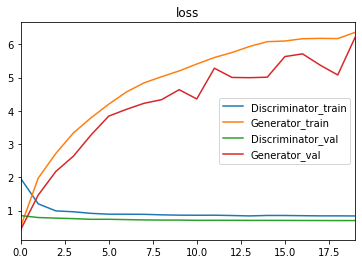

In [360]:
pd.DataFrame(np.array([[np.mean(x) for x in batches_losses_D], [np.mean(x) for x in batches_losses_G], [np.mean(x) for x in val_losses_D], [np.mean(x) for x in val_losses_G]]).T,
                   columns=['Discriminator_train', 'Generator_train', 'Discriminator_val', 'Generator_val']).plot(title="loss")

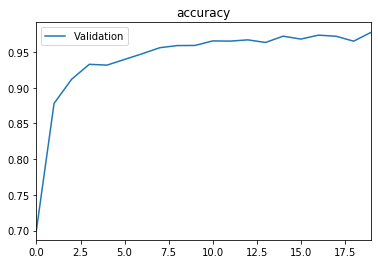

In [361]:
pd.DataFrame(np.array(val_acc).T,
                   columns=['Validation']).plot(title="accuracy")

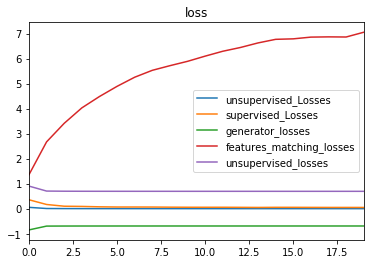

In [373]:
pd.DataFrame(np.array([[np.mean(x) for x in unsupervised_Losses], [np.mean(x) for x in supervised_Losses], [np.mean(x) for x in generator_losses], [np.mean(x) for x in features_matching_losses], [np.mean(x) for x in unsupervised_losses]]).T,
                   columns=['unsupervised_Losses', 'supervised_Losses', 'generator_losses', 'features_matching_losses', 'unsupervised_losses']).plot(title="loss")

In [372]:
print(f"maximal Accuracy of {round(max(val_acc),2)} on the epoch {np.argmax(val_acc)+1}")

maximal Accuracy of 0.98 on the epoch 20


In [16]:
# test on MNIST

generator_model_test=torch.load("./mnist/SemiSupervisedGAN/generator/SemiSupervisedGAN_generator_model_epoch20.pt")
discriminator_model_test=torch.load("./mnist/SemiSupervisedGAN/discriminator/SemiSupervisedGAN_discriminator_model_epoch20.pt")
test_losses=[]
test_acc=[]
t1=time.time()
test_dataset = MNIST('./data', transform=img_transform,train=False)# download=True)
test_mnist_dataset=MNIST_Dataset(test_dataset)
test_data_loader=DataLoader(
    test_mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE)
output, target, test_losses_D, test_losses_G, test_conditional_entropies_real, test_marginal_entropies_real, test_cross_entropies, test_conditional_entropies_fake, test_marginal_entropies_fake=eval_loop_fun1(test_data_loader, discriminator_model_test, generator_model_test, latent_size, TRAIN_BATCH_SIZE, device, λ)
print(f"==> evaluation : avg_discriminator_loss = {np.mean(test_losses_D):.2f}, avg_generator_loss = {np.mean(test_losses_G):.2f}, time : {time.time()-t1:.2f} sec\n")
test_evaluate=evaluate(target.reshape(-1), output)
print(f"=====>\t{test_evaluate}")
# test_acc.append(test_evaluate['accuracy'])
# test_losses.append(test_losses_D, test_losses_G)

==> evaluation : avg_discriminator_loss = 0.70, avg_generator_loss = 6.28, time : 14.28 sec

=====>	{'accuracy': 0.979, 'nb exemple': 10000, 'true_prediction': 9790, 'false_prediction': 210}


In [379]:
Generator()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(10, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (10): Tanh()
  )
)

In [378]:
Discriminator()

Discriminator(
  (main): Sequential(
    (0): Dropout2d(p=0.08, inplace=False)
    (1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2)
    (10): Dropout2d(p=0.2, inplace=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), p